#### Necessary imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import LSTM
from tensorflow.keras.layers import LSTM
from keras.layers import Conv3D, MaxPooling3D
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#### Data Preprocessing

In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def process_images(row):
    cleaned_string = row.replace('[', '').replace(']', '').replace('\n', '') # Remove brackets and newlines
    float_array = np.array([float(x) for x in cleaned_string.split()]).reshape(7, 9) # Convert to a numpy array of floats and reshape
    return float_array

def data_preprocessing(n_future, x, y, yfilter):
    data = pd.DataFrame([x, y, yfilter]).transpose()
    data.columns = ['rainfall', 'S.W', 'S.W.F']
    data = data[n_future:] # slicing and removing first n_future records
    return data

def reshapeImages(image, sequence_length) -> np.array:
    X = []
    image = np.array(image.tolist())
    for i in range(len(image)-sequence_length):
        X.append(image[i : i + sequence_length])
    X = np.asarray(X).astype(np.float32)
    X = X.reshape(X.shape[0], sequence_length, 7, 9)
    return np.array(X)

def normalisingImages(image):
    normalized_arr = image
    for i in range(len(image)):
        a = image.iloc[i].reshape(-1,1)
        normalized_arr[i] = ((StandardScaler().fit(a)).transform(a)).reshape(1,-1)
    return normalized_arr

In [3]:
df = pd.read_csv('../data/sourcedata/Data.csv', index_col='Zeit')
df.index.name = None
df['Value'] = df['Value'].apply(process_images)
df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d %H:%M')

In [4]:
x = df['Value']
y = df['SennhuetteMin15W']
window = 8
yfilter = pd.Series(moving_average(y, window))
yfilter.index = y[:-(window-1)].index
n_past = 32 #8 hours into the past

#### Splitting dataset

In [5]:
def split_data(data, n, n_past):    
    n_train = int(len(data)*0.6) # Split into train and test datasets
    train = data[0:n_train]
    test = data[n_train:]
    
    train.to_csv(f'../final results/STRPM/Qualitative/{n}hrs/train_{n}h.csv')
    test.to_csv(f'../final results/STRPM/Qualitative/{n}hrs/test_{n}h.csv')

    train_X = reshapeImages(train['rainfall'], n_past)
    test_X = reshapeImages(test['rainfall'], n_past)

    train_y = train['S.W.F'][n_past:]
    test_y = test['S.W'][n_past:]
    test_SW = test['S.W.F'][n_past:]

    print(f"Shape of X_train: {train_X.shape}, y_train: {train_y.shape}")
    print(f"Shape of X_test: {test_X.shape}, y_test: {test_y.shape}")
    print(f"Shape of train_SW, test_SW: {test_SW.shape}")

    return train_X, train_y, test_X, test_y, test_SW

#### Plotting functions

In [6]:
def convert_to_dataframe(true, predicted, index, label1, label2, n): 
    df = pd.DataFrame([])
    df.index = index
    df[label1] = true
    df[label2] = predicted
    return df

def plot_pred(actual, pred, title, n):
    plt.plot(actual[172800:173300], label='actual')
    plt.plot(pred[172800:173300], label='predicted')
    plt.title(title)
    plt.xticks(actual.index[172800:173300][::100], rotation=45)
    plt.legend(loc='upper right')
    plt.savefig(f'../final results/STRPM/Qualitative/{n}hrs/{title}.png')
    plt.show()

def plotTrainingLoss(history, n) -> None:
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.savefig(f'../final results/STRPM/Qualitative/{n}hrs/trainingloss_{n}hrs.png')
    plt.show()

#### Special Convolutional model

In [7]:
def Conv2plus1d(input_shape):
    filters = 1
    kernel_size = [3,3,3]
    model = Sequential(name="specialconvmodel")
    model.add(Conv3D(filters, kernel_size=(1, kernel_size[1], kernel_size[2]), padding="same", activation='tanh', input_shape = input_shape))  # Spatial decomposition
    model.add(Conv3D(filters, kernel_size=(kernel_size[0], 1, 1), padding="same", activation="tanh")) # Temporal decomposition
    model.add(MaxPooling3D(pool_size=2, strides=2, padding="same"))
    
    model.add(Conv3D(3, kernel_size=(1, kernel_size[1], kernel_size[2]), padding="same", activation='tanh', input_shape = input_shape))  # Spatial decomposition
    model.add(Conv3D(3, kernel_size=(kernel_size[0], 1, 1), padding="same", activation="tanh")) # Temporal decomposition
    model.add(MaxPooling3D(pool_size=2, strides=2, padding="same"))
    model.add(Conv3D(6, kernel_size=(1, kernel_size[1], kernel_size[2]), padding="same", activation='tanh', input_shape = input_shape))  # Spatial decomposition
    model.add(Conv3D(6, kernel_size=(kernel_size[0], 1, 1), padding="same", activation="tanh")) # Temporal decomposition   
    return model


def neuralnetwork(X_train, y_train, n):
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)
    y_train = (np.asarray(y_train).astype(np.float32)).reshape(-1,1)
    
    model = Conv2plus1d(input_shape)
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(8))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units = 1, activation = 'linear')) 
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    model.build()
    model.summary()
    history = model.fit(X_train, y_train, epochs=30, batch_size=256, validation_split=0.2) 
    plotTrainingLoss(history, n)
    model.save(f'../final results/STRPM/Qualitative/{n}hrs/model_{n}hrs.h5')
    return model

#### Prediction framework

In [ ]:
def evaluatemodel(model, test_x, test_y, n):
    model.evaluate(test_x, (np.asarray(test_y).astype(np.float32)).reshape(-1,1), return_dict=True)
    y_pred = model.predict(test_x)
    prediction = convert_to_dataframe(test_y, y_pred, test_y.index, 'measured', 'predicted', n)
    prediction.to_csv(f'../final results/STRPM/Qualitative/{n}hrs/forecasts_{n}h.csv') 
    plot_pred(prediction['ytrue'], prediction['ypred'], f'{n}hrs-forecasts', n)
    return prediction

#### 2hours forecast using Water levels directly

In [9]:
n_future =  8
data2 = data_preprocessing(n_future, x, y, yfilter)
train_X2, train_y2, test_X2, test_y2, test_SW2 = split_data(data2, int(n_future/4), n_past)

Shape of X_train: (308468, 32, 7, 9), y_train: (308468,)
Shape of X_test: (205636, 32, 7, 9), y_test: (205636,)
Shape of train_SW, test_SW: (205636,)




Model: "specialconvmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 32, 7, 9, 1)       10        
                                                                 
 conv3d_1 (Conv3D)           (None, 32, 7, 9, 1)       4         
                                                                 
 max_pooling3d (MaxPooling3  (None, 16, 4, 5, 1)       0         
 D)                                                              
                                                                 
 conv3d_2 (Conv3D)           (None, 16, 4, 5, 3)       30        
                                                                 
 conv3d_3 (Conv3D)           (None, 16, 4, 5, 3)       30        
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 8, 2, 3, 3)        0         
 g3D)                                           

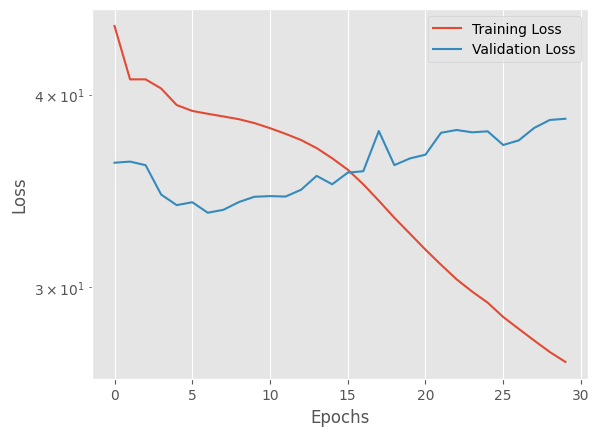

c:\Users\ss97\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
model2 = neuralnetwork(train_X2, train_y2, int(n_future/4)) #train with 2plus1D CNN-LSTM model

6427/6427 [==============================] - 27s 4ms/step


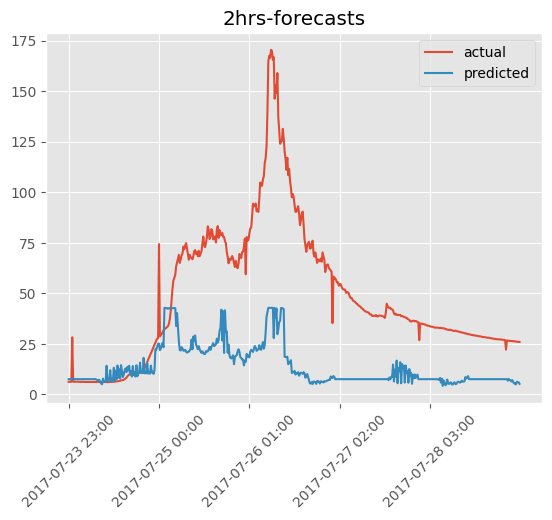

In [11]:
predictions2 = evaluatemodel(model2, test_X2, test_y2, int(n_future/4)) #predictions

#### 3-hours forecast using water levels directly

In [12]:
n_future =  12
data3 = data_preprocessing(n_future, x, y, yfilter)
train_X3, train_y3, test_X3, test_y3, test_SW3 = split_data(data3, int(n_future/4), n_past)

Shape of X_train: (308466, 32, 7, 9), y_train: (308466,)
Shape of X_test: (205634, 32, 7, 9), y_test: (205634,)
Shape of train_SW, test_SW: (205634,)


Model: "specialconvmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 32, 7, 9, 1)       10        
                                                                 
 conv3d_7 (Conv3D)           (None, 32, 7, 9, 1)       4         
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 16, 4, 5, 1)       0         
 g3D)                                                            
                                                                 
 conv3d_8 (Conv3D)           (None, 16, 4, 5, 3)       30        
                                                                 
 conv3d_9 (Conv3D)           (None, 16, 4, 5, 3)       30        
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 8, 2, 3, 3)        0         
 g3D)                                             

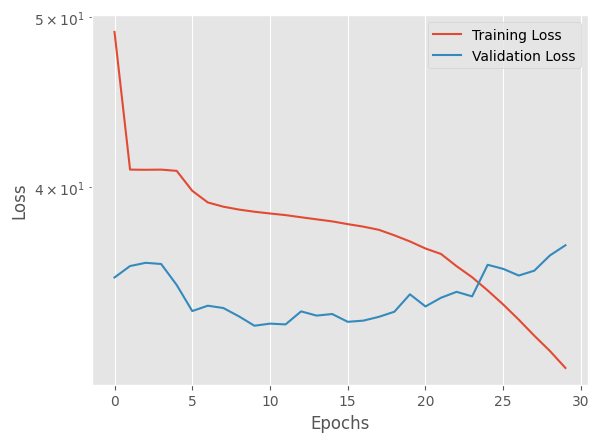

c:\Users\ss97\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
model3 = neuralnetwork(train_X3, train_y3, int(n_future/4))

6427/6427 [==============================] - 61s 9ms/step


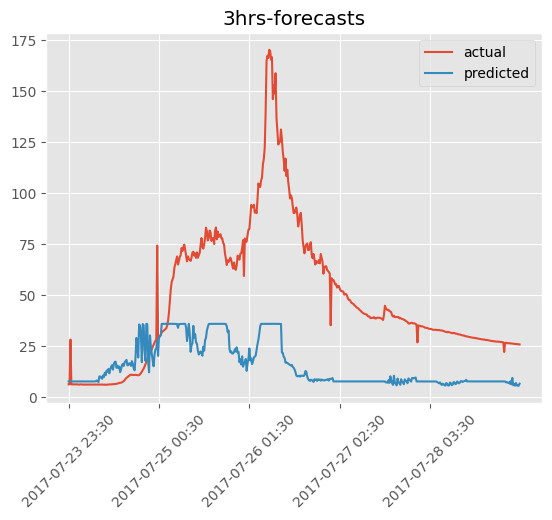

In [14]:
predictions3 = evaluatemodel(model3, test_X3, test_y3, int(n_future/4)) 

#### 4-hours forecast using water levels directly

In [15]:
n_future =  16
data4 = data_preprocessing(n_future, x, y, yfilter)
train_X4, train_y4, test_X4, test_y4, test_SW4 = split_data(data4, int(n_future/4), n_past)

Shape of X_train: (308464, 32, 7, 9), y_train: (308464,)
Shape of X_test: (205632, 32, 7, 9), y_test: (205632,)
Shape of train_SW, test_SW: (205632,)


Model: "specialconvmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 32, 7, 9, 1)       10        
                                                                 
 conv3d_13 (Conv3D)          (None, 32, 7, 9, 1)       4         
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 16, 4, 5, 1)       0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 16, 4, 5, 3)       30        
                                                                 
 conv3d_15 (Conv3D)          (None, 16, 4, 5, 3)       30        
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 8, 2, 3, 3)        0         
 g3D)                                             

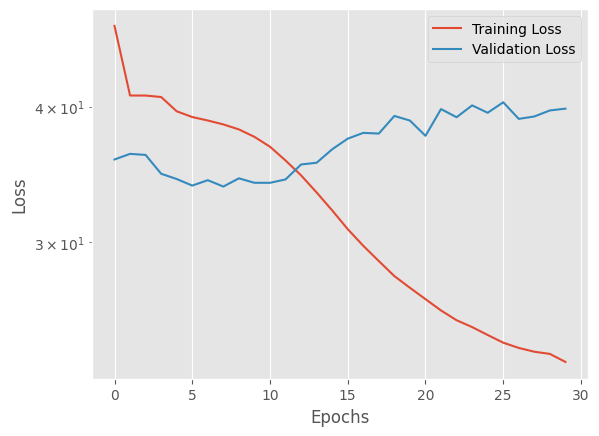

c:\Users\ss97\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
model4 = neuralnetwork(train_X4, train_y4, int(n_future/4))

6426/6426 [==============================] - 27s 4ms/step


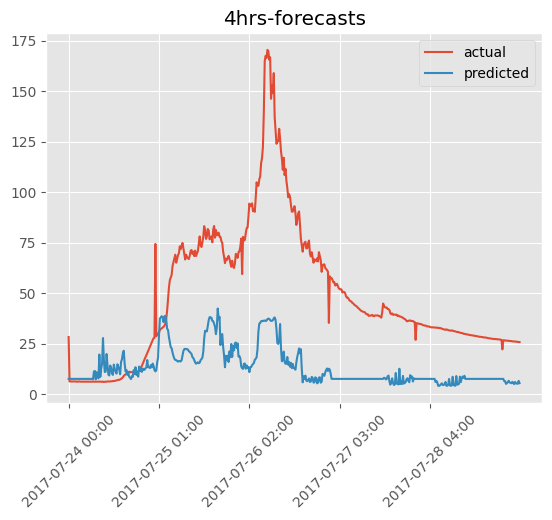

In [17]:
predictions4 = evaluatemodel(model4, test_X4, test_y4, 4) 

#### 8-hours forecast using water levels directly

In [18]:
n_future =  32
data8 = data_preprocessing(n_future, x, y, yfilter)
train_X8, train_y8, test_X8, test_y8, test_SW8 = split_data(data8, int(n_future/4), n_past)

Shape of X_train: (308454, 32, 7, 9), y_train: (308454,)
Shape of X_test: (205626, 32, 7, 9), y_test: (205626,)
Shape of train_SW, test_SW: (205626,)


Model: "specialconvmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 32, 7, 9, 1)       10        
                                                                 
 conv3d_19 (Conv3D)          (None, 32, 7, 9, 1)       4         
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 16, 4, 5, 1)       0         
 g3D)                                                            
                                                                 
 conv3d_20 (Conv3D)          (None, 16, 4, 5, 3)       30        
                                                                 
 conv3d_21 (Conv3D)          (None, 16, 4, 5, 3)       30        
                                                                 
 max_pooling3d_7 (MaxPoolin  (None, 8, 2, 3, 3)        0         
 g3D)                                             

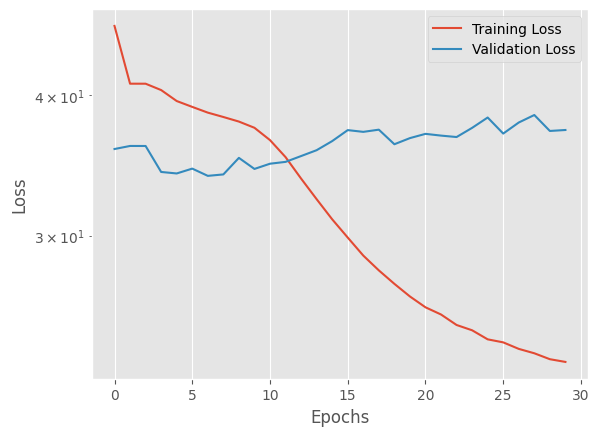

c:\Users\ss97\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
model8 = neuralnetwork(train_X8, train_y8, int(n_future/4))

6426/6426 [==============================] - 25s 4ms/step


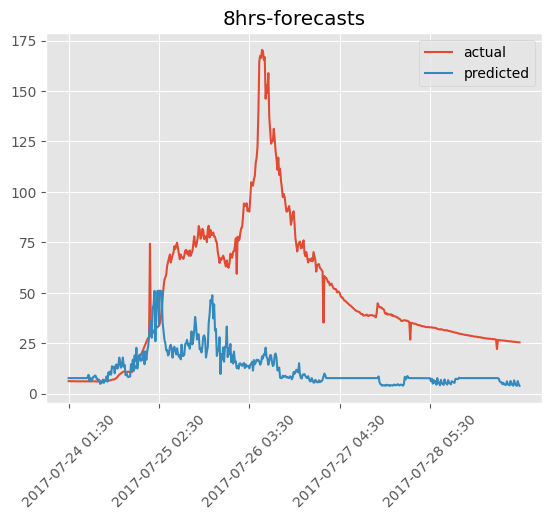

In [20]:
predictions8 = evaluatemodel(model8, test_X8, test_y8, int(n_future/4)) 

#### 12-hours forecast using water levels directly

In [21]:
n_future = 48
data12 = data_preprocessing(n_future, x, y, yfilter)
train_X12, train_y12, test_X12, test_y12, test_SW12 = split_data(data12, int(n_future/4), n_past)

Shape of X_train: (308444, 32, 7, 9), y_train: (308444,)
Shape of X_test: (205620, 32, 7, 9), y_test: (205620,)
Shape of train_SW, test_SW: (205620,)


Model: "specialconvmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 32, 7, 9, 1)       10        
                                                                 
 conv3d_25 (Conv3D)          (None, 32, 7, 9, 1)       4         
                                                                 
 max_pooling3d_8 (MaxPoolin  (None, 16, 4, 5, 1)       0         
 g3D)                                                            
                                                                 
 conv3d_26 (Conv3D)          (None, 16, 4, 5, 3)       30        
                                                                 
 conv3d_27 (Conv3D)          (None, 16, 4, 5, 3)       30        
                                                                 
 max_pooling3d_9 (MaxPoolin  (None, 8, 2, 3, 3)        0         
 g3D)                                             

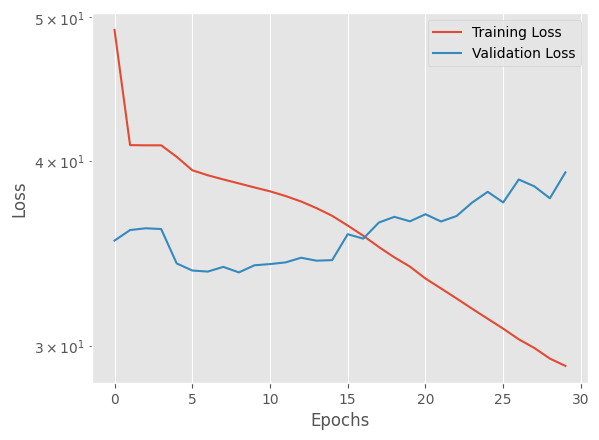

c:\Users\ss97\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
model12 = neuralnetwork(train_X12, train_y12, int(n_future/4))

6426/6426 [==============================] - 28s 4ms/step


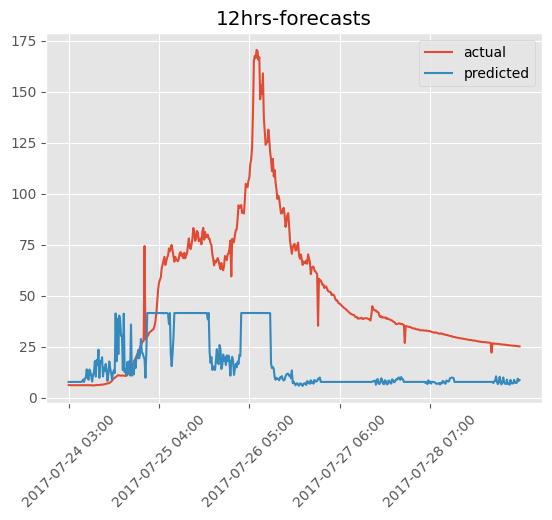

In [23]:
predictions12 = evaluatemodel(model12, test_X12, test_y12, int(n_future/4)) 

#### MSE

In [25]:
mse_strpm_2 = np.round(mean_squared_error(test_y2, predictions2['ypred']),4)
mse_strpm_3 = np.round(mean_squared_error(test_y3, predictions3['ypred']),4)
mse_strpm_4 = np.round(mean_squared_error(test_y4, predictions4['ypred']),4)
mse_strpm_8 = np.round(mean_squared_error(test_y8, predictions8['ypred']),4)
mse_strpm_12 = np.round(mean_squared_error(test_y12, predictions12['ypred']),4)

##### STRPM MSE

In [26]:
mse_strpm_2, mse_strpm_3, mse_strpm_4, mse_strpm_8, mse_strpm_12

(39.294, 37.0361, 40.6746, 39.8148, 39.466)